# SPML HW3: Breaking Defenses & Black-Box Attacks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
name = 'AmirHossein Haji Mohammad Rezaei'
std_id = '99109252'

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.models import resnet18, mobilenet_v2
from torchvision.datasets.cifar import CIFAR10

from tqdm import trange, tqdm
import matplotlib.pyplot as plt

torch.manual_seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# CIFAR10 Dataset (5 points)

In [ ]:
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)
batch_size = 128

mu = torch.tensor(norm_mean).view(3,1,1).to(device)
std = torch.tensor(norm_std).view(3,1,1).to(device)

# TODO: Set the upper limit and lower limit possible for images
upper_limit = ...
lower_limit = ...

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:03<00:00, 42.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Defensive Distillation (25 points)

[Defensive distillation](https://arxiv.org/abs/1511.04508) proceeds in four steps:

1.   **Train the teacher network**, by setting the temperature of the softmax to T during the
training phase.
2.   **Compute soft labels** by apply the teacher network to each instance in the training set, again evaluating the softmax at temperature T.
3.  **Train the distilled network** (a network with the same shape as the teacher network) on the soft labels, using softmax at temperature T.
4.  Finally, when running the distilled network at test time to classify new inputs, use temperature 1.



## Train the teacher

In [ ]:
def train_step(model, dataloader, loss_fn, optimizer, temperature):
    # TODO: Return loss and accuracy for each epoch
    model.train()
    avg_loss = 0
    correct = 0
    total = 0

    with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:
      for i, (img, label) in pbar:
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        logit = model(img)
        logit /= temperature
        loss = loss_fn(logit, label)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        correct += torch.sum(logit.argmax(dim=1) == label).item()
        total += img.shape[0]

    avg_loss /= total
    avg_acc = correct / total
    return avg_loss, avg_acc



def train_teacher(model, n_epochs, loader=trainloader, temp=100):
    # TODO: Log the accuracy and loss for each epoch
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = CrossEntropyLoss()
    for epoch in range(1, n_epochs + 1):
      avg_loss, avg_acc = train_step(model, loader, loss_fn, optimizer, temp)

      print(f'[train] epoch: {epoch}: average loss={avg_loss:.2f}, average accuracy={avg_acc:.2f}')

You can use a pre-trained resnet to speed up the training process.

In [ ]:
class resnet(nn.Module):
  def __init__(self, num_cls, pretrained=True):
    super().__init__()
    self.conv = nn.Sequential(*list(resnet18(pretrained=pretrained).children())[:-2])
    self.fc = nn.Linear(512, num_cls)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    return logits

teacher = resnet(10, True).to(device)

train_teacher(teacher, 15)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 391/391 [00:20<00:00, 19.04it/s]

[train] epoch: 1: average loss=0.01, average accuracy=0.36



100%|██████████| 391/391 [00:20<00:00, 18.69it/s]

[train] epoch: 2: average loss=0.01, average accuracy=0.53



100%|██████████| 391/391 [00:24<00:00, 15.80it/s]

[train] epoch: 3: average loss=0.01, average accuracy=0.62



100%|██████████| 391/391 [00:22<00:00, 17.73it/s]

[train] epoch: 4: average loss=0.01, average accuracy=0.66



100%|██████████| 391/391 [00:19<00:00, 19.85it/s]

[train] epoch: 5: average loss=0.01, average accuracy=0.70



100%|██████████| 391/391 [00:20<00:00, 18.78it/s]

[train] epoch: 6: average loss=0.01, average accuracy=0.72



100%|██████████| 391/391 [00:20<00:00, 19.29it/s]

[train] epoch: 7: average loss=0.01, average accuracy=0.74



100%|██████████| 391/391 [00:20<00:00, 19.02it/s]

[train] epoch: 8: average loss=0.01, average accuracy=0.75



100%|██████████| 391/391 [00:20<00:00, 18.81it/s]

[train] epoch: 9: average loss=0.01, average accuracy=0.76



100%|██████████| 391/391 [00:19<00:00, 19.80it/s]

[train] epoch: 10: average loss=0.01, average accuracy=0.78



100%|██████████| 391/391 [00:21<00:00, 18.09it/s]

[train] epoch: 11: average loss=0.00, average accuracy=0.78



100%|██████████| 391/391 [00:20<00:00, 18.64it/s]

[train] epoch: 12: average loss=0.00, average accuracy=0.79



100%|██████████| 391/391 [00:20<00:00, 18.82it/s]

[train] epoch: 13: average loss=0.00, average accuracy=0.80



100%|██████████| 391/391 [00:19<00:00, 19.85it/s]

[train] epoch: 14: average loss=0.00, average accuracy=0.80



100%|██████████| 391/391 [00:21<00:00, 18.47it/s]

[train] epoch: 15: average loss=0.00, average accuracy=0.81


## Test the teacher

In [ ]:
def test_clean(model, dataloader=testloader):
    # TODO: Return the clean accuracy of the model
    model.eval()
    correct = 0
    total = 0

    with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:
      for i, (img, label) in pbar:
        img = img.to(device)
        label = label.to(device)

        logit = model(img)
        prob = F.softmax(logit, dim=1)
        correct += torch.sum(prob.argmax(dim=1) == label).item()
        total += img.shape[0]

    avg_acc = correct / total
    return avg_acc

Print the clean accuracy of the teacher.

In [ ]:
print(f'Teacher Accuracy {100 * test_clean(teacher):.2f}%')

100%|██████████| 79/79 [00:01<00:00, 41.68it/s]

Teacher Accuracy 78.85%


## Train the student

In [ ]:
def distill(model, teacher, dataloader, optimizer, T):
    # TODO: Get soft labels from teacher model
    # TODO: Get student model outputs
    # TODO: Compute the distillation loss
    # TODO: Return the accuracy (on real labels) and loss (on soft labels)
    model.train()
    teacher.eval()

    avg_loss = 0
    correct = 0
    total = 0

    with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:
      for i, (img, label) in pbar:
        img = img.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        with torch.no_grad():
          teacher_logits = teacher(img)

        student_logits = model(img)

        soft_targets = F.softmax(teacher_logits / T, dim=-1)
        soft_prob = F.log_softmax(student_logits / T, dim=-1)

        soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)


        soft_targets_loss.backward()
        optimizer.step()

        avg_loss += soft_targets_loss.item()
        correct += torch.sum(student_logits.argmax(dim=1) == label).item()
        total += img.shape[0]

    avg_loss /= total
    avg_acc = correct / total
    return avg_loss, avg_acc


def train_student(model, teacher, n_epochs, loader=trainloader, temp=100):
    # TODO: Log the accuracy and loss for each epoch
    optimizer = Adam(model.parameters(), lr=0.01)

    for epoch in range(1, n_epochs + 1):
      avg_loss, avg_acc = distill(model, teacher, loader, optimizer, temp)
      print(f'[train student] epoch: {epoch}: average loss={avg_loss:.2f}, average accuracy={avg_acc:.2f}')

This time use a `resnet18` without the pretrained weights.

In [ ]:
student = resnet(10, False).to(device)

train_student(student, teacher, 15)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 391/391 [00:22<00:00, 17.25it/s]

[train student] epoch: 1: average loss=84.64, average accuracy=0.37



100%|██████████| 391/391 [00:22<00:00, 17.69it/s]

[train student] epoch: 2: average loss=51.11, average accuracy=0.56



100%|██████████| 391/391 [00:21<00:00, 18.13it/s]

[train student] epoch: 3: average loss=35.09, average accuracy=0.64



100%|██████████| 391/391 [00:22<00:00, 17.38it/s]

[train student] epoch: 4: average loss=27.03, average accuracy=0.69



100%|██████████| 391/391 [00:22<00:00, 17.44it/s]

[train student] epoch: 5: average loss=22.42, average accuracy=0.71



100%|██████████| 391/391 [00:21<00:00, 18.15it/s]

[train student] epoch: 6: average loss=18.87, average accuracy=0.73



100%|██████████| 391/391 [00:22<00:00, 17.29it/s]

[train student] epoch: 7: average loss=16.71, average accuracy=0.75



100%|██████████| 391/391 [00:22<00:00, 17.20it/s]

[train student] epoch: 8: average loss=15.60, average accuracy=0.75



100%|██████████| 391/391 [00:21<00:00, 17.96it/s]

[train student] epoch: 9: average loss=14.31, average accuracy=0.76



100%|██████████| 391/391 [00:22<00:00, 17.35it/s]

[train student] epoch: 10: average loss=13.44, average accuracy=0.77



100%|██████████| 391/391 [00:23<00:00, 16.53it/s]

[train student] epoch: 11: average loss=13.05, average accuracy=0.77



100%|██████████| 391/391 [00:22<00:00, 17.41it/s]

[train student] epoch: 12: average loss=12.55, average accuracy=0.77



100%|██████████| 391/391 [00:22<00:00, 17.53it/s]

[train student] epoch: 13: average loss=11.98, average accuracy=0.78



100%|██████████| 391/391 [00:22<00:00, 17.02it/s]

[train student] epoch: 14: average loss=11.53, average accuracy=0.78



100%|██████████| 391/391 [00:23<00:00, 16.96it/s]

[train student] epoch: 15: average loss=11.18, average accuracy=0.78


## Test the student

In [ ]:
print(f'Student Accuracy {test_clean(student):.2f}%')

100%|██████████| 79/79 [00:02<00:00, 29.17it/s]

Student Accuracy 0.78%


# Attack (15 points)

Implement the FGSM attack and the `test_attack` funcion to report the robust accuracy for different values of epsilon.

In [ ]:
def attack_fgsm(model, x, y, epsilon):
    # TODO: Return perturbed input
    criterion = CrossEntropyLoss()

    x.requires_grad = True
    model.zero_grad()
    logit = model(x)
    loss = criterion(logit, y)
    loss.backward()

    adv_x = x + epsilon*x.grad.data.sign()
    adv_x = torch.clamp(adv_x, 0, 1)

    return adv_x


def attack_pgd(model, x, y, epsilon, alpha=0.2, num_iters=10):
    # TODO: Return perturbed input
    criterion = nn.CrossEntropyLoss()
    pert_x = x.clone().to(device)

    for _ in range(num_iters):
      pert_x.requires_grad = True
      logit = model(pert_x)

      model.zero_grad()
      loss = criterion(logit, y)
      loss.backward()

      adv_x = pert_x + alpha*pert_x.grad.data.sign()
      eta = torch.clamp(adv_x - x, min=-epsilon, max=epsilon)
      pert_x = torch.clamp(x + eta, min=0, max=1).detach_()

    return pert_x



def test_attack(model, epsilon, attack=attack_fgsm, loader=testloader):
    # TODO: Return the robust accuracy for FGSM or PGD
    model.eval()

    correct = 0
    total = 0
    with tqdm(iterable=enumerate(loader), total=len(loader)) as pbar:
      for i, (img, label) in pbar:
        img = img.to(device)
        label = label.to(device)

        adv_img = attack(model, img, label, epsilon)
        logit = model(adv_img)

        prob = F.softmax(logit, dim=-1)
        correct += torch.sum(prob.argmax(dim=1) == label).item()
        total += img.shape[0]

    avg_acc = correct / total
    return avg_acc


Report the robust accuracy of the teacher for `ϵ = [1, 2, 4, 8, 16]`.

In [ ]:
epsilons = [1, 2, 4, 8, 16]

for eps in epsilons:
    print('***********')
    fgsm_acc = test_attack(teacher, eps / 255, attack_fgsm)
    print(f'FGSM with ϵ={eps}/255 has Accuracy: {100 * fgsm_acc:.2f}%')
    pgd_acc = test_attack(teacher, eps / 255, attack_pgd)
    print(f'PGD  with ϵ={eps}/255 has Accuracy: {100 * pgd_acc:.2f}%')
    print('***********')

***********


100%|██████████| 79/79 [00:04<00:00, 19.48it/s]

FGSM with ϵ=1/255 has Accuracy: 71.07%



100%|██████████| 79/79 [00:23<00:00,  3.39it/s]

PGD  with ϵ=1/255 has Accuracy: 70.71%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 25.23it/s]

FGSM with ϵ=2/255 has Accuracy: 70.74%



100%|██████████| 79/79 [00:23<00:00,  3.32it/s]

PGD  with ϵ=2/255 has Accuracy: 70.58%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 24.67it/s]

FGSM with ϵ=4/255 has Accuracy: 70.64%



100%|██████████| 79/79 [00:23<00:00,  3.36it/s]

PGD  with ϵ=4/255 has Accuracy: 70.57%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 21.37it/s]

FGSM with ϵ=8/255 has Accuracy: 70.64%



100%|██████████| 79/79 [00:23<00:00,  3.33it/s]

PGD  with ϵ=8/255 has Accuracy: 70.90%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 20.23it/s]

FGSM with ϵ=16/255 has Accuracy: 70.65%



100%|██████████| 79/79 [00:23<00:00,  3.35it/s]

PGD  with ϵ=16/255 has Accuracy: 71.89%
***********


Do the same for the student:

In [ ]:
for eps in epsilons:
    print('***********')
    fgsm_acc = test_attack(student, eps / 255, attack_fgsm)
    print(f'FGSM with ϵ={eps}/255 has Accuracy: {100 * fgsm_acc:.2f}%')
    pgd_acc = test_attack(student, eps / 255, attack_pgd)
    print(f'PGD  with ϵ={eps}/255 has Accuracy: {100 * pgd_acc:.2f}%')
    print('***********')

***********


100%|██████████| 79/79 [00:04<00:00, 19.71it/s]

FGSM with ϵ=1/255 has Accuracy: 69.48%



100%|██████████| 79/79 [00:23<00:00,  3.36it/s]

PGD  with ϵ=1/255 has Accuracy: 68.84%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 22.91it/s]

FGSM with ϵ=2/255 has Accuracy: 68.75%



100%|██████████| 79/79 [00:23<00:00,  3.30it/s]

PGD  with ϵ=2/255 has Accuracy: 68.46%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 25.16it/s]

FGSM with ϵ=4/255 has Accuracy: 68.50%



100%|██████████| 79/79 [00:23<00:00,  3.35it/s]

PGD  with ϵ=4/255 has Accuracy: 68.35%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 24.87it/s]


FGSM with ϵ=8/255 has Accuracy: 68.40%


100%|██████████| 79/79 [00:23<00:00,  3.35it/s]

PGD  with ϵ=8/255 has Accuracy: 68.56%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 24.99it/s]

FGSM with ϵ=16/255 has Accuracy: 68.48%



100%|██████████| 79/79 [00:23<00:00,  3.33it/s]

PGD  with ϵ=16/255 has Accuracy: 69.87%
***********


What do you see?

`your response:` Defensive distillation made the model robust against fgsm and PGD adversarial examples.

# Transferring Adversarial Examples (15 points)

Train yet another model to be used as the surrogate. (set temperature to 1)

In [ ]:
model = resnet(10, False).to(device)

train_teacher(model, 15, temp=1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 391/391 [00:21<00:00, 18.31it/s]

[train] epoch: 1: average loss=0.01, average accuracy=0.32



100%|██████████| 391/391 [00:23<00:00, 16.31it/s]

[train] epoch: 2: average loss=0.01, average accuracy=0.47



100%|██████████| 391/391 [00:21<00:00, 18.08it/s]

[train] epoch: 3: average loss=0.01, average accuracy=0.55



100%|██████████| 391/391 [00:21<00:00, 18.50it/s]

[train] epoch: 4: average loss=0.01, average accuracy=0.61



100%|██████████| 391/391 [00:20<00:00, 18.71it/s]

[train] epoch: 5: average loss=0.01, average accuracy=0.65



100%|██████████| 391/391 [00:21<00:00, 18.00it/s]

[train] epoch: 6: average loss=0.01, average accuracy=0.68



100%|██████████| 391/391 [00:22<00:00, 17.37it/s]

[train] epoch: 7: average loss=0.01, average accuracy=0.71



100%|██████████| 391/391 [00:19<00:00, 19.63it/s]

[train] epoch: 8: average loss=0.01, average accuracy=0.73



100%|██████████| 391/391 [00:20<00:00, 19.27it/s]

[train] epoch: 9: average loss=0.01, average accuracy=0.74



100%|██████████| 391/391 [00:21<00:00, 17.99it/s]

[train] epoch: 10: average loss=0.01, average accuracy=0.76



100%|██████████| 391/391 [00:20<00:00, 19.44it/s]

[train] epoch: 11: average loss=0.01, average accuracy=0.77



100%|██████████| 391/391 [00:22<00:00, 17.51it/s]

[train] epoch: 12: average loss=0.01, average accuracy=0.78



100%|██████████| 391/391 [00:19<00:00, 19.86it/s]

[train] epoch: 13: average loss=0.00, average accuracy=0.78



100%|██████████| 391/391 [00:20<00:00, 18.93it/s]

[train] epoch: 14: average loss=0.00, average accuracy=0.79



100%|██████████| 391/391 [00:19<00:00, 19.73it/s]

[train] epoch: 15: average loss=0.00, average accuracy=0.80


Print the surrogate accuracy.

In [ ]:
print(f'Surrogate Accuracy {100 * test_clean(model):.2f}%')

100%|██████████| 79/79 [00:01<00:00, 43.21it/s]

Surrogate Accuracy 76.08%


Report the accuracy of the surrogate for `ϵ = [1, 2, 4, 8, 16]`.

In [ ]:
for eps in epsilons:
    print('***********')
    fgsm_acc = test_attack(model, eps / 255, attack_fgsm)
    print(f'FGSM with ϵ={eps}/255 has Accuracy: {100 * fgsm_acc:.2f}%')
    pgd_acc = test_attack(model, eps / 255, attack_pgd)
    print(f'PGD  with ϵ={eps}/255 has Accuracy: {100 * pgd_acc:.2f}%')
    print('***********')

***********


100%|██████████| 79/79 [00:03<00:00, 24.42it/s]

FGSM with ϵ=1/255 has Accuracy: 55.67%



100%|██████████| 79/79 [00:23<00:00,  3.31it/s]

PGD  with ϵ=1/255 has Accuracy: 54.66%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 24.60it/s]

FGSM with ϵ=2/255 has Accuracy: 38.76%



100%|██████████| 79/79 [00:24<00:00,  3.26it/s]

PGD  with ϵ=2/255 has Accuracy: 36.17%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 24.64it/s]

FGSM with ϵ=4/255 has Accuracy: 19.07%



100%|██████████| 79/79 [00:23<00:00,  3.29it/s]

PGD  with ϵ=4/255 has Accuracy: 17.27%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 21.64it/s]

FGSM with ϵ=8/255 has Accuracy: 5.54%



100%|██████████| 79/79 [00:23<00:00,  3.30it/s]

PGD  with ϵ=8/255 has Accuracy: 6.87%
***********
***********



100%|██████████| 79/79 [00:03<00:00, 20.82it/s]

FGSM with ϵ=16/255 has Accuracy: 2.08%



100%|██████████| 79/79 [00:24<00:00,  3.23it/s]

PGD  with ϵ=16/255 has Accuracy: 5.72%
***********


Implement the following functions to transfer attacks from a surrogate model to an oracle.

In [ ]:
def transfer_attack(oracle, model, eps, loader=testloader):
    # TODO: Attack the model and report the accuracy of the oracle
    oracle.eval()

    correct = 0
    total = 0
    with tqdm(iterable=enumerate(loader), total=len(loader)) as pbar:
      for i, (img, label) in pbar:
        img = img.to(device)
        label = label.to(device)

        adv_img = attack_fgsm(model, img, label, eps)
        logit = oracle(adv_img)

        prob = F.softmax(logit, dim=-1)
        correct += torch.sum(prob.argmax(dim=1) == label).item()
        total += img.shape[0]

    avg_acc = correct / total
    return avg_acc

Transfer attacks for `ϵ = [1, 2, 4, 8, 16]` from your model to the student.

In [ ]:
for eps in epsilons:
    acc = transfer_attack(student, model, eps/255)
    print(f'FGSM with ϵ={eps}/255 has Accuracy: {100 * acc:.2f}%')

100%|██████████| 79/79 [00:03<00:00, 21.73it/s]

FGSM with ϵ=1/255 has Accuracy: 73.49%



100%|██████████| 79/79 [00:03<00:00, 25.19it/s]

FGSM with ϵ=2/255 has Accuracy: 67.78%



100%|██████████| 79/79 [00:03<00:00, 20.00it/s]

FGSM with ϵ=4/255 has Accuracy: 55.64%



100%|██████████| 79/79 [00:03<00:00, 25.30it/s]

FGSM with ϵ=8/255 has Accuracy: 35.87%



100%|██████████| 79/79 [00:03<00:00, 25.19it/s]

FGSM with ϵ=16/255 has Accuracy: 17.26%


- What can be inferred from these results?
- How are the accuracies of the student and the surrogate under attack related?
- Does Defensive Distillation obfuscate the gradients? Why?

`your response:`
We can conclude that the Defensive distillation cause obfuscated gradients. Because, black-box attack (trasnferring) was very successful compared to the white-box attack on the student model.

# ZOO Based Black-Box Attacks (25 points)

Based on [Black-box Adversarial Attacks with Limited Queries and Information](https://arxiv.org/abs/1804.08598) you must first calculate the estimate of the graidents, and next attack the model based on your estimates.

In [ ]:
def nes_gradient_estimate(model, x, y, epsilon, num_samples, sigma):
    # TODO: Return the estimated gradient
    model.eval()
    criterion = nn.CrossEntropyLoss()

    noise = torch.randn((num_samples * x.shape[0], 3, 32, 32)).squeeze(1).to(device)
    x_tile = x.repeat(num_samples, 1, 1, 1, 1, 1).view(-1, 3, 32, 32).to(device)
    y_tile = y.repeat(num_samples, 1).view(-1).to(device)

    logit = model(x_tile + sigma * noise)
    loss = criterion(logit, y_tile)
    grad = torch.sum((noise * loss.item()).view((num_samples, x.shape[0], 3, 32, 32)), dim=0)

    # logit = model(x_tile - sigma * noise)
    # loss = criterion(logit, y_tile)
    # grad += torch.sum((-noise * loss.item()).view((num_samples, x.shape[0], 3, 32, 32)), dim=0)

    grad /= num_samples * sigma

    return grad

In [ ]:
def partial_information_attack(model, x, y, epsilon, num_samples=100, sigma=0.1, num_steps=10, alpha=0.001):
  pert_x = x.clone().to(device)

  for _ in range(num_steps):
    grad = nes_gradient_estimate(model, pert_x, y, epsilon, num_samples, sigma)

    adv_x = pert_x + alpha*grad.sign()
    eta = torch.clamp(adv_x - x, min=-epsilon, max=epsilon)
    pert_x = torch.clamp(x + eta, min=0, max=1).detach_()

  return pert_x

Now run this attack on your models and report the results. (You **DON'T** need to run the attack for the entire test dataset as this will take a lot of time!)

In [ ]:
def short_test_attack(model, epsilon, attack, loader=testloader):
    # TODO: Return the robust accuracy for FGSM or PGD
    model.eval()

    correct = 0
    total = 0
    adv_imgs = []
    with tqdm(iterable=enumerate(loader), total=len(loader)) as pbar:
      for i, (img, label) in pbar:
        if i == 5:
          break

        img = img.to(device)
        label = label.to(device)

        adv_img = attack(model, img, label, epsilon)
        logit = model(adv_img)

        prob = F.softmax(logit, dim=-1)
        correct += torch.sum(prob.argmax(dim=1) == label).item()
        total += img.shape[0]
        adv_imgs.append(adv_img[prob.argmax(dim=1) != label])

    avg_acc = correct / total
    return adv_imgs, avg_acc

In [ ]:
adv_imgs, avg_acc = short_test_attack(model, 0.05, partial_information_attack, loader=testloader)
print(f'accuracy for reduced testset for partial information attack={avg_acc * 100:.2f}%')

  6%|▋         | 5/79 [00:39<09:49,  7.96s/it]

accuracy for reduced testset for partial information attack=79.22%


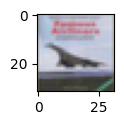

In [ ]:
fig = plt.figure(figsize=(1, 1))
plt.imshow(adv_imgs[0][0].cpu().permute(1, 2, 0).numpy())

# Adversarially Robust Distillation (15 points)

In this section we are going to test another type of distillation to see if this method is robust. This technique is [Adversarially Robust Distillation](https://arxiv.org/abs/1905.09747).



1.   We will try to distill a robsut teacher from [Robust Bench](https://robustbench.github.io/) onto a smaller architecture.
2.   We minimize the KL-Divergence between the logits of the student and teacher to ensure fidelity. (You can also incorporate the classification loss as mentioned in the paper but you can choose to ignore it as well)
3.   At each step of the distillation you will attack the student (you can use either FGSM or PGD) and find an adversarial example $X + \delta$ for data point $X$. Next you will minimize $t^2 \times \text{KL}(S(X+\delta), T(X))$ where $S$ and $T$ are the student and teacher networks respectively.



In [ ]:
! pip install git+https://github.com/RobustBench/robustbench.git

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-wwmma4za
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-wwmma4za
  Resolved https://github.com/RobustBench/robustbench.git to commit 776bc95bb4167827fb102a32ac5aea62e46cfaab
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /tmp/pip-install-9ife3k8r/autoattack_e20e33ba0bf14418a2787ef72f478f51
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-install-9ife3k8r/autoattack_e20e33ba0bf14418a2787ef72f478f51
  Running command git rev-parse -q --verify 'sha^a39220048b3c9f2cca9a4d3a54604793c68eca7e'
  Running command git fetch -q https://github.com/fra31/auto-attack.git a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4

In [ ]:
from robustbench.utils import load_model

teacher = load_model(model_name='Gowal2021Improving_R18_ddpm_100m', dataset='cifar10', threat_model='Linf')

/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


Downloading...
From (original): https://drive.google.com/uc?id=1-0EuCJashqSXEkkd1DOzFA4tH8KL2kim
From (redirected): https://drive.google.com/uc?id=1-0EuCJashqSXEkkd1DOzFA4tH8KL2kim&confirm=t&uuid=64ba792d-efcc-4128-9a23-a27c7418aedc
To: /content/models/cifar10/Linf/Gowal2021Improving_R18_ddpm_100m.pt
100%|██████████| 50.3M/50.3M [00:00<00:00, 51.3MB/s]
/usr/local/lib/python3.10/dist-packages/robustbench/utils.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless th

In [ ]:
def ard(student, teacher, dataloader, optimizer, eps, attack):
    # TODO
    T = 100
    student.train()
    teacher.eval()

    avg_loss = 0
    correct = 0
    total = 0

    with tqdm(iterable=enumerate(dataloader), total=len(dataloader)) as pbar:
      for i, (img, label) in pbar:
        img = img.to(device)
        label = label.to(device)

        adv_img = attack(student, img, label, eps)

        optimizer.zero_grad()
        with torch.no_grad():
          teacher_logits = teacher(img)

        student_logits = student(adv_img)

        soft_targets = F.softmax(teacher_logits / T, dim=-1)
        soft_prob = F.log_softmax(student_logits / T, dim=-1)

        soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)


        soft_targets_loss.backward()
        optimizer.step()

        avg_loss += soft_targets_loss.item()
        correct += torch.sum(student_logits.argmax(dim=1) == label).item()
        total += img.shape[0]

    avg_loss /= total
    avg_acc = correct / total
    return avg_loss, avg_acc


def adv_train_student(model, teacher, n_epochs, eps=8/255, loader=trainloader):
  optimizer = Adam(model.parameters(), lr=0.01)

  for epoch in range(1, n_epochs + 1):
    avg_loss, avg_acc = ard(model, teacher, loader, optimizer, eps, attack_fgsm)
    print(f'[ARD train] epoch {epoch}: mean loss: {avg_loss:.2f}, mean accuracy: {100 * avg_acc:.2f}%')

In [ ]:
student = mobilenet_v2(weights=None)
student.classifier[1] = nn.Linear(1280, 10)
student = student.to(device)

teacher = teacher.to(device)

# TODO: Adjust and train the student

adv_train_student(student, teacher, 15)

100%|██████████| 391/391 [00:39<00:00,  9.79it/s]

[ARD train] epoch 1: mean loss: 0.03, mean accuracy: 14.18%



100%|██████████| 391/391 [00:43<00:00,  9.07it/s]

[ARD train] epoch 2: mean loss: 0.03, mean accuracy: 17.91%



100%|██████████| 391/391 [00:41<00:00,  9.47it/s]

[ARD train] epoch 3: mean loss: 0.02, mean accuracy: 23.32%



100%|██████████| 391/391 [00:40<00:00,  9.61it/s]

[ARD train] epoch 4: mean loss: 0.02, mean accuracy: 29.58%



100%|██████████| 391/391 [00:42<00:00,  9.30it/s]

[ARD train] epoch 5: mean loss: 0.02, mean accuracy: 34.01%



100%|██████████| 391/391 [00:40<00:00,  9.69it/s]

[ARD train] epoch 6: mean loss: 0.02, mean accuracy: 38.64%



100%|██████████| 391/391 [00:41<00:00,  9.32it/s]

[ARD train] epoch 7: mean loss: 0.02, mean accuracy: 42.39%



100%|██████████| 391/391 [00:41<00:00,  9.42it/s]

[ARD train] epoch 8: mean loss: 0.01, mean accuracy: 44.48%



100%|██████████| 391/391 [00:41<00:00,  9.32it/s]

[ARD train] epoch 9: mean loss: 0.01, mean accuracy: 49.28%



100%|██████████| 391/391 [00:42<00:00,  9.26it/s]

[ARD train] epoch 10: mean loss: 0.01, mean accuracy: 50.88%



100%|██████████| 391/391 [00:40<00:00,  9.60it/s]

[ARD train] epoch 11: mean loss: 0.01, mean accuracy: 55.25%



100%|██████████| 391/391 [00:42<00:00,  9.29it/s]

[ARD train] epoch 12: mean loss: 0.01, mean accuracy: 59.79%



100%|██████████| 391/391 [00:40<00:00,  9.58it/s]

[ARD train] epoch 13: mean loss: 0.01, mean accuracy: 63.91%



100%|██████████| 391/391 [00:41<00:00,  9.37it/s]

[ARD train] epoch 14: mean loss: 0.01, mean accuracy: 63.29%



100%|██████████| 391/391 [00:41<00:00,  9.36it/s]

[ARD train] epoch 15: mean loss: 0.01, mean accuracy: 68.10%


Now report the accuracy of the student on the test dataset.

In [ ]:
# TODO: Clean accurcy

clean_acc = test_clean(student)
print(f'clean accuracy = {clean_acc * 100:.2f}%')
# TODO: FGSM with eps=8/255

fgsm_acc = test_attack(student, 8/255, attack_fgsm)
print(f'fgsm accuracy = {fgsm_acc * 100:.2f}%')
# TODO: PGD with eps=8/255

pgd_acc = test_attack(student, 8/255, attack_pgd)
print(f'PGD accuracy = {pgd_acc * 100:.2f}%')

100%|██████████| 79/79 [00:02<00:00, 33.81it/s]

clean accuracy = 60.71%



100%|██████████| 79/79 [00:03<00:00, 20.86it/s]

fgsm accuracy = 50.08%



100%|██████████| 79/79 [00:18<00:00,  4.21it/s]

PGD accuracy = 44.32%
